


```
- Machine Learning, Innopolis University (Fall semester 2021)
- Name : Ahmed Mohsen Ali
- Email : a.ali@innopolis.university
```
<hr>

# **Task_3**

# **1.Preprocess and visualize the dataset**



In [ ]:
#upload the file
%%capture
!wget https://www2.unavarra.es/gesadj/GI4E/gi4e_database.zip
!sudo apt install unzip 
!unzip gi4e_database.zip

In [ ]:
#import the necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import glob
import cv2
import numpy as np
import pandas as pd
import  matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter
from google.colab.patches import cv2_imshow
from torch.utils.data import TensorDataset, DataLoader

**1.0 Upload the datasets from the images folder in a greyscale**

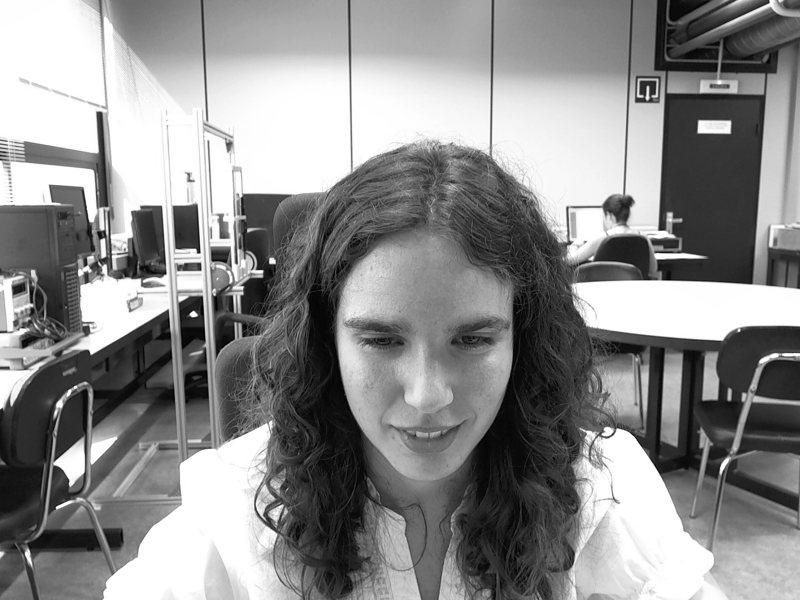

In [ ]:
images = [cv2.imread(file,0) for file in sorted(glob.glob("/content/images/*.png"))] 
images=np.array(images)       #convert images to numpy
cv2_imshow(images[0])  #show the first image in the dataset


**1.1 Read annotation for images. It contains eye corners and eye centers of 2 eyes for each image using pandas**

In [ ]:
#Read the labels.txt into pandas dataframe
data = pd.read_csv("/content/labels/image_labels.txt", delim_whitespace=True, header=None)  
data.columns = ["Image_name", "l_extrenal_x","l_extrenal_y", "l_center_x","l_center_y", "l_internal_x","l_internal_y","r_internal_x","r_internal_y", "r_center_x","r_center_y", "r_extrenal_x","r_extrenal_y"]

#coverting the pixels into integers
data.loc[:, data.columns != 'Image_name']=data.loc[:, data.columns != 'Image_name'].astype(int)



#Loading coordinates of the left eye landmarks into numpy arrays
l_internal=data[['l_internal_x', 'l_internal_y']].apply(tuple, axis=1)
l_external=data[['l_extrenal_x', 'l_extrenal_y']].apply(tuple, axis=1)
l_center=data[['l_center_x', 'l_center_y']].apply(tuple, axis=1)

#Loading coordinates of the right eye landmarks into numpy arrays
r_internal=data[['r_internal_x', 'r_internal_y']].apply(tuple, axis=1)
r_external=data[['r_extrenal_x', 'r_extrenal_y']].apply(tuple, axis=1)
r_center=data[['r_center_x', 'r_center_y']].apply(tuple, axis=1)





**1.2 Visualize one image, draw eye corners and iris centers on it**

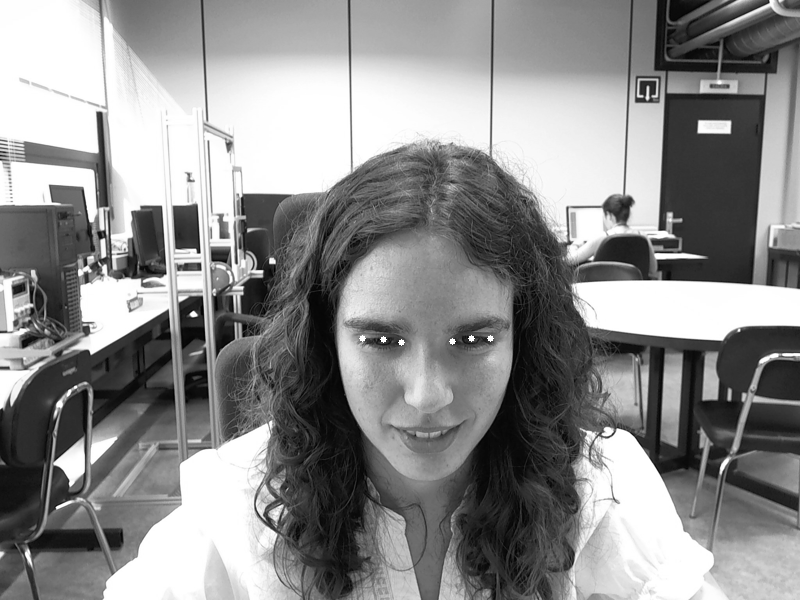

In [ ]:
#Using cv2.circle to detect the landamrks for two iris
i=0
#read the first image
vis_image=  cv2.imread("/content/images/001_01.png",0)

# detect the landamrks for left iris
vis_image = cv2.circle(vis_image,l_internal[i], radius=0, color=(255, 0, 0), thickness=5)
vis_image = cv2.circle(vis_image, l_external[i], radius=0, color=(255, 0, 0), thickness=5)
vis_image= cv2.circle(vis_image, l_center[i], radius=0, color=(255, 0, 0), thickness=5)

# detect the landamrks for right iris
vis_image= cv2.circle(vis_image,r_internal[i], radius=0, color=(255, 0, 0), thickness=5)
vis_image= cv2.circle(vis_image, r_external[i], radius=0, color=(255, 0, 0), thickness=5)
vis_image= cv2.circle(vis_image, r_center[i], radius=0, color=(255, 0, 0), thickness=5)

cv2_imshow(vis_image)


**1.3 Crop into left eye regions with 48*48 pixels**

We will take left eye as the input. No need for both eyes

(48, 48)


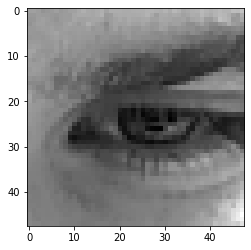

In [ ]:
cropped_images=[]
for i in range(len(images)):
      #calculate new origin for the cropped image as upper left corner of eye
      origin_x = l_internal[i][0]
      origin_y = l_external[i][1]

      #Make offset for the origin by 24 in y and 10 in x.
      crop=images[i][origin_y-24:origin_y+24,origin_x-10:origin_x+38]
      cropped_images.append(crop)
# conver to numpy array      
cropped_images=np.array(cropped_images)

#show the first cropped image and print its dimension
plt.imshow(cropped_images[0],cmap='gray')
print(cropped_images[0].shape)

**1.4 Normalize cropped images (divide by 255)**





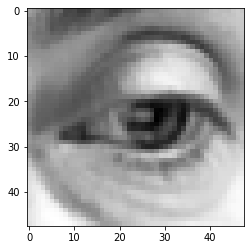

In [ ]:
normalized=cropped_images/255.0
#show an image after normalization
plt.imshow(normalized[500],cmap='gray')


**1.5 Extracting X,Y datasets**

In this step, x is the normalized cropped images (48*48) and Y contains the iris center. However, there are some preprocessing needs to be done on Y such as:

*  The Y images  (48*48) is all black except for a white point indicating the iris center
*   Dilation is performed to enlarge the area of iris center
*   Guassian Distribution is done on iris center to blure the area of iris center

These steps are performed to enhance the stability of the system.








In [ ]:
#X is the normalized eyes region images 48*48
X=normalized

#kernel for dilation process
kernel = np.ones((3,3),np.uint8)
tmp=np.zeros((48,48))
Y=[]
new_iris=[]

#This for loop caluclates the new coordinates of iris center in new cropped images
for i in range(len(images)):
  tmp=np.zeros((48,48))
  new = (l_center[i][1]-l_external[i][1]+24,l_center[i][0]-l_internal[i][0]+10)
  new_iris.append(new)   #new iris coordinates are put into a list for later use
  tmp[new]=1
  tmp = gaussian_filter(tmp, 1)
  tmp = cv2.dilate(tmp,kernel,iterations = 1)
  Y.append(tmp)
  
Y=np.array(Y)


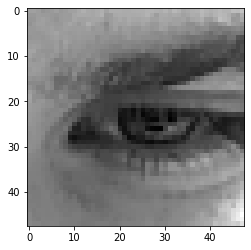

In [ ]:
#Show the first image in X dataset
plt.imshow(X[0],cmap='gray')

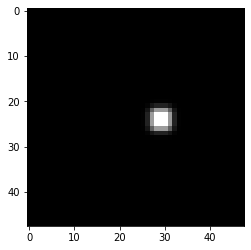

In [ ]:
#Plot the firt item in Y for visualization
plt.imshow(Y[0],cmap='gray')

In [ ]:
print("The shape of X and Y datasets are: ",X.shape,Y.shape)

The shape of X and Y datasets are:  (1236, 48, 48) (1236, 48, 48)


**1.6 Split the datasets**

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

#insert axis in x_train, x_test to fit the dimensions of the CNN model 
x_train = np.expand_dims(x_train, 1)
y_train = np.expand_dims(y_train, 1)
x_test = np.expand_dims(x_test, 1)
y_test = np.expand_dims(y_test, 1)

print("The shape of X and Y datasets are: ",x_test.shape,x_train.shape,y_test.shape,y_train.shape)

The shape of X and Y datasets are:  (248, 1, 48, 48) (988, 1, 48, 48) (248, 1, 48, 48) (988, 1, 48, 48)


Now, the preprocessing of data is ready and the train and test dataset to enter the model

# **2. Build The model using Pytorch**
We will build the model using Autoencoder idea. The model consists of the following  parts :
 
*   Base Netwrok 
*   Auxiliary Network
*   Skip Connection



**2.1 Build The ConvAutoencoder class**

In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        ## encoder layers ##
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)  
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1) 
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        

        ## Base Network ##
        self.t_conv1 = nn.ConvTranspose2d(256, 64, 4, stride=4)
        self.conv4 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv5 = nn.Conv2d(64, 1, 3, padding=1)

        ##Auxiliary Network ##
        self.t_conv2 = nn.ConvTranspose2d(256, 128, 4, stride=2,padding=1)
        self.t_conv3 =nn.ConvTranspose2d(128, 64, 4, stride=2,padding=1)


    def forward(self, x):
        ## Encoder ##
        x1 = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x1))
        x = self.pool1(x) 
        x = F.relu(self.conv3(x))
        x = self.pool2(x) 
    
        ## Base Network ##
        y1 = F.relu(self.t_conv1(x))
        y1=torch.cat((x1,y1),1)
        y1 = F.relu(self.conv4(y1))
        y1 = torch.tanh(self.conv5(y1))

         ##Auxiliary Network ##
        y2 = F.relu(self.t_conv2(x))
        y2 = F.relu(self.t_conv3(y2))
        y2 = torch.tanh(self.conv5(y2))
     
        return y1,y2


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model=ConvAutoencoder().to(device)


**2.2 Define train and Test Functions**

In [ ]:
def train( model, device, train_loader, optimizer, epoch,loss_func):
    model.train()
    epoch_loss=0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y1,y2 = model(data)
        loss1 = loss_func(y1, target)
        loss2 = loss_func(y2, data)
        total_loss = loss1+loss2
        total_loss.backward()
        optimizer.step()
        epoch_loss += total_loss.item()
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, epoch, total_loss.item()))
        

def test( model, device, test_loader,loss_func):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
         for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            view_data=data
            y1,y2 = model(data)
            test_loss += loss_func(y1, target).item()   # sum up batch loss
           
         test_loss /= len(test_loader.dataset)
         print('\nTest set: Average loss: {:.4f}'.format( test_loss)  )  
    return y1,view_data


# **3. Train and Test the model**

In [ ]:
#This function is used to convert the tensor into image
def tensor_to_image(tensor):
    tensor1 = tensor.cpu().numpy()
    tensor1 =tensor1.reshape([48, 48])
    return tensor1

epoch [2/1], loss:0.0056
epoch [2/1], loss:0.0822
epoch [2/1], loss:0.0170
epoch [2/1], loss:0.0391
epoch [2/1], loss:0.0306
epoch [2/1], loss:0.0068
epoch [2/1], loss:0.0096
epoch [2/1], loss:0.0213
epoch [2/1], loss:0.0193
epoch [2/1], loss:0.0112
epoch [2/1], loss:0.0055
epoch [2/1], loss:0.0074
epoch [2/1], loss:0.0133
epoch [2/1], loss:0.0114
epoch [2/1], loss:0.0078
epoch [2/1], loss:0.0056

Test set: Average loss: 0.0000
1
epoch [3/2], loss:0.0068
epoch [3/2], loss:0.0095
epoch [3/2], loss:0.0100
epoch [3/2], loss:0.0077
epoch [3/2], loss:0.0049
epoch [3/2], loss:0.0058
epoch [3/2], loss:0.0068
epoch [3/2], loss:0.0082
epoch [3/2], loss:0.0054
epoch [3/2], loss:0.0042
epoch [3/2], loss:0.0045
epoch [3/2], loss:0.0061
epoch [3/2], loss:0.0057
epoch [3/2], loss:0.0045
epoch [3/2], loss:0.0044
epoch [3/2], loss:0.0053

Test set: Average loss: 0.0000
2
epoch [4/3], loss:0.0051
epoch [4/3], loss:0.0043
epoch [4/3], loss:0.0043
epoch [4/3], loss:0.0042
epoch [4/3], loss:0.0045
epoch [

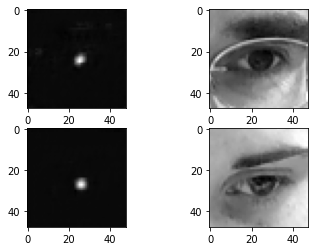

In [ ]:
#CNN hyperparameters
batchSize = 64
learning_rate = 0.001
epochs = 50
criterion1 = nn.MSELoss()
criterion2 = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

# transform train and test data to torch tensors
tensor_x = torch.Tensor(x_train) 
tensor_y = torch.Tensor(y_train)
tensor_x_test = torch.Tensor(x_test) 
tensor_y_test = torch.Tensor(y_test)


# Build the dataloaders
train_loader = DataLoader(TensorDataset(tensor_x,tensor_y),batch_size=batchSize,shuffle=True)
test_loader = DataLoader(TensorDataset(tensor_x_test,tensor_y_test),batch_size=batchSize, shuffle=False)

#train and test the model
for epoch in range(1, epochs + 1):
  train(model, device, train_loader, optimizer, epoch,criterion1)
  y_pred , data = test(model, device, test_loader,criterion1)
  print(epoch)


#plot the figures
f = plt.figure()
f.add_subplot(2,2, 1)
plt.imshow( tensor_to_image(y_pred[10]),cmap='gray')
f.add_subplot(2,2, 2)
plt.imshow( tensor_to_image(data[10]),cmap='gray')
f.add_subplot(2,2, 3)
plt.imshow( tensor_to_image(y_pred[20]),cmap='gray')
f.add_subplot(2,2, 4)
plt.imshow( tensor_to_image(data[20]),cmap='gray')
plt.show(block=True)


# **4.0 Make Predictions**
We will use the model now to make predict for 10 images and draw the expected iris center on them.
The images on the left are the output from the CNN and on the right are the images sampled from the test data with red circle represents the expected iris center on them.

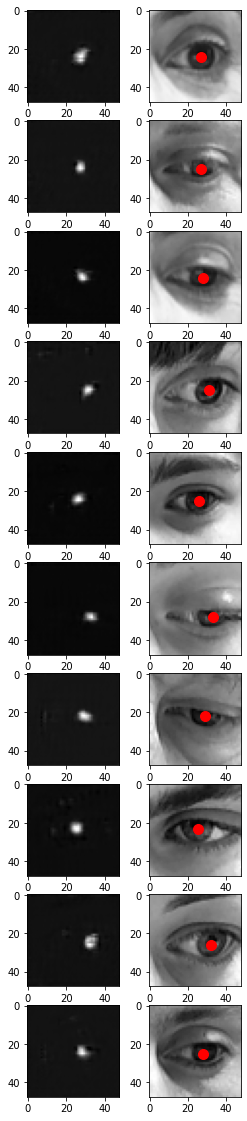

In [ ]:

f = plt.figure(figsize=[4,20])
for i in range(0,10):
  left= tensor_to_image(y_pred[i])
  right=tensor_to_image(data[i])

  (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(left)
  f.add_subplot(10,2,i*2+1)
  plt.imshow( left,cmap='gray')
 

  f.add_subplot(10,2, i*2+2)
  plt.imshow( right,cmap='gray')
  plt.plot( maxLoc[0],  maxLoc[1], 'r.', markersize=20.0)

# **5.0 Conclusion**

This model has been performed with multiple iterations between the following parameters:
*   optimizers : [sgd, adam, adamax, rmsprop]
*   loss functions : [mse,mae]
*   activations : [tanh, relu, sigmoid]



The **best combination** was for:
*   optimizers : Adam
*   loss functions : MSE
*   activations : Tanh

